# Bollinger's analysis and position limits

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
plt.style.use('seaborn')

## Getting csv data with historical ask, bid values

In [34]:
csv_filepath = 'test_data/e5bd6481-6804-4177-ab89-77290e04517c.csv'
csv_trade = pd.read_csv(csv_filepath, sep=';')

In [35]:
df_banana = csv_trade[csv_trade['product'] == 'BANANAS'].sort_values(by=["timestamp"])
df_pearl = csv_trade[csv_trade['product'] == 'PEARLS'].sort_values(by=["timestamp"])

In [36]:
df_pearl.tail()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
3991,-1,199500,PEARLS,9996,1,9995.0,21.0,NaN,NaN,9998,2,10004.0,1.0,10005.0,21.0,9997.0,2058.0
3992,-1,199600,PEARLS,9995,28,NaN,NaN,NaN,NaN,10005,28,NaN,NaN,NaN,NaN,10000.0,2058.0
3995,-1,199700,PEARLS,10002,1,9996.0,2.0,9995.0,28.0,10004,2,10005.0,28.0,NaN,NaN,10003.0,2058.0
3997,-1,199800,PEARLS,9996,1,9995.0,27.0,NaN,NaN,10004,1,10005.0,27.0,NaN,NaN,10000.0,2058.0
3999,-1,199900,PEARLS,9998,9,9995.0,25.0,NaN,NaN,10005,25,NaN,NaN,NaN,NaN,10001.5,2058.0


In [37]:
df_banana.tail()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
3990,-1,199500,BANANAS,4930,22,NaN,NaN,NaN,NaN,4937,22,NaN,NaN,NaN,NaN,4933.5,1355.6094
3993,-1,199600,BANANAS,4930,28,NaN,NaN,NaN,NaN,4937,28,NaN,NaN,NaN,NaN,4933.5,1357.2031
3994,-1,199700,BANANAS,4931,30,NaN,NaN,NaN,NaN,4937,2,4938.0,28.0,NaN,NaN,4934.0,1374.5156
3996,-1,199800,BANANAS,4931,1,4930.0,27.0,NaN,NaN,4937,28,NaN,NaN,NaN,NaN,4934.0,1367.4766
3998,-1,199900,BANANAS,4931,9,4930.0,25.0,NaN,NaN,4932,3,4937.0,25.0,NaN,NaN,4931.5,1367.8125


In [38]:
csv_trade.groupby('product').agg({'mid_price': ['mean', 'std', 'min', 'max']})

mid_price                           
              mean       std     min      max
product                                      
BANANAS  4938.2895  7.958996  4924.5   4956.0
PEARLS   9999.9935  1.493427  9996.5  10003.5

## Getting log file to extract positions

In [143]:
positions = {
    'timestamp': [],
    'BANANAS': [],
    'PEARLS': [],
}
position_well_defined = False
position_taken = False
with open('test_data/e5bd6481-6804-4177-ab89-77290e04517c.log', 'r') as logfile:
    for line in logfile.readlines():
        if 'state.own_trades' in line and position_well_defined:
            splitted_str = line.split("state.own_trades")
            try:
                timestamp = int(splitted_str[0])
                positions["timestamp"].append(timestamp)
                #print(timestamp)
            except ValueError:
                continue
            position_taken = False
        
        if "state.position" in line and not position_taken:
            current_position = line.split("state.position =")[1]
            #values = re.findall(r'\d+', line)
            values = re.findall(r'-?\d+\.?\d*', line)
            if len(values) == 0:
                continue
                #positions["BANANAS"].append(0)
                #positions["PEARLS"].append(0)
            elif len(values) == 1:
                position_taken = True
                position_well_defined = True
                if "BANANAS" in current_position:
                    positions["BANANAS"].append(float(values[0]))
                    positions["PEARLS"].append(0)
                if "PEARLS" in current_position:
                    positions["BANANAS"].append(0)
                    positions["PEARLS"].append(float(values[0]))
                    
            elif len(values) == 2:
                #print(values)
                position_taken = True
                position_well_defined = True
                positions["BANANAS"].append(float(values[0]))
                positions["PEARLS"].append(float(values[1]))

# pop the latest ones
positions["PEARLS"].pop(-1)
positions["BANANAS"].pop(-1)
logfile.close()
    
df_positions = pd.DataFrame(positions)

## Bollinger's band Analysis 
### First for Bananas

In [144]:
def SMA(data, period, column = 'mid_price'):
    return data[column].rolling(window = period).mean()

# Setting up Bananas DF
df_banana['SMA20'] = SMA(df_banana, 20)
df_banana['SMA50'] = SMA(df_banana, 50)
df_banana['SMA80'] = SMA(df_banana, 80)
df_banana['stdev'] = df_banana.mid_price.rolling(window = 20).std()
df_banana['Upper'] = df_banana.SMA20 + 2*df_banana.stdev
df_banana['Lower'] = df_banana.SMA20 - 2*df_banana.stdev 
 # Buy & Sell signals
df_banana['Buy_Signal'] = np.where(df_banana.Lower > df_banana.mid_price, True, False)
df_banana['Sell_Signal'] = np.where(df_banana.Upper < df_banana.mid_price, True, False)

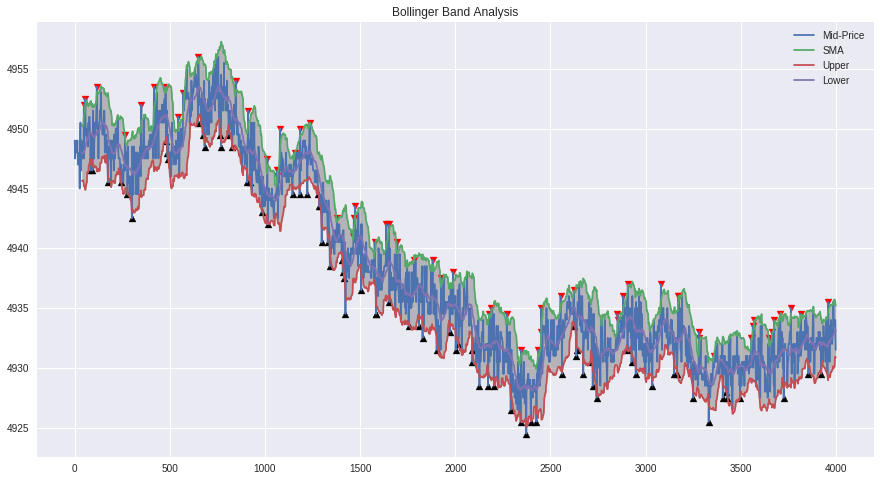

In [145]:
plt.figure(figsize = (15,8))
plt.plot(df_banana[['mid_price', 'Upper', 'Lower', 'SMA20']])
plt.fill_between(df_banana.index, df_banana.Upper, df_banana.Lower, color = 'grey', alpha = 0.5)
plt.scatter(df_banana.index[df_banana.Buy_Signal], df_banana[df_banana.Buy_Signal].mid_price, marker = '^', color = 'black')
plt.scatter(df_banana.index[df_banana.Sell_Signal], df_banana[df_banana.Sell_Signal].mid_price, marker = 'v', color = 'red')
plt.title('Bollinger Band Analysis')
plt.legend(['Mid-Price', 'SMA', 'Upper', 'Lower'])

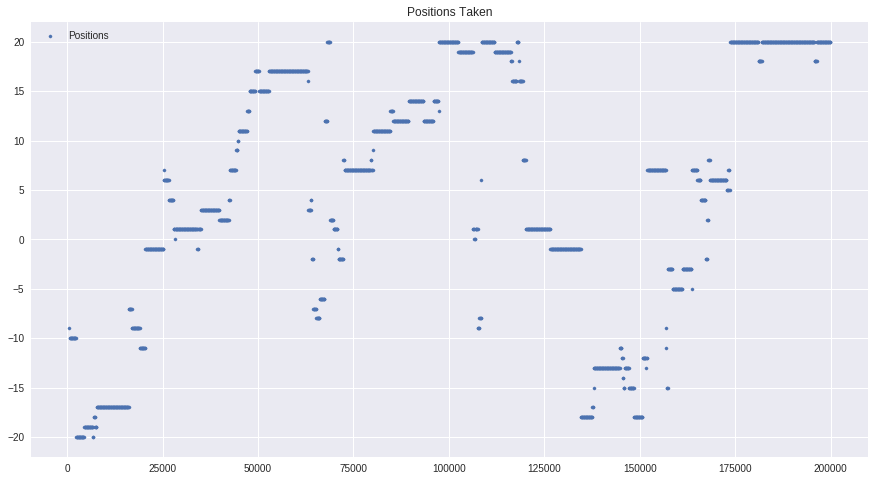

In [153]:
plt.figure(figsize = (15,8))
plt.scatter(df_positions['timestamp'], df_positions["BANANAS"], s=10)
plt.title('Positions Taken')
plt.legend(["Positions"])

### Now for pearls

In [26]:
def SMA(data, period, column = 'mid_price'):
    return data[column].rolling(window = period).mean()

# Setting up Bananas DF
df_pearl['SMA20'] = SMA(df_pearl, 20)
df_pearl['SMA50'] = SMA(df_pearl, 50)
df_pearl['SMA80'] = SMA(df_pearl, 80)
df_pearl['stdev'] = df_pearl.mid_price.rolling(window = 20).std()
df_pearl['Upper'] = df_pearl.SMA20 + 1*df_pearl.stdev # using 2 x standard deviation
df_pearl['Lower'] = df_pearl.SMA20 - 1*df_pearl.stdev
df_pearl['Buy_Signal'] = np.where(df_pearl.Lower > df_pearl.mid_price, True, False) # Buy & Sell signals
df_pearl['Sell_Signal'] = np.where(df_pearl.Upper < df_pearl.mid_price, True, False)

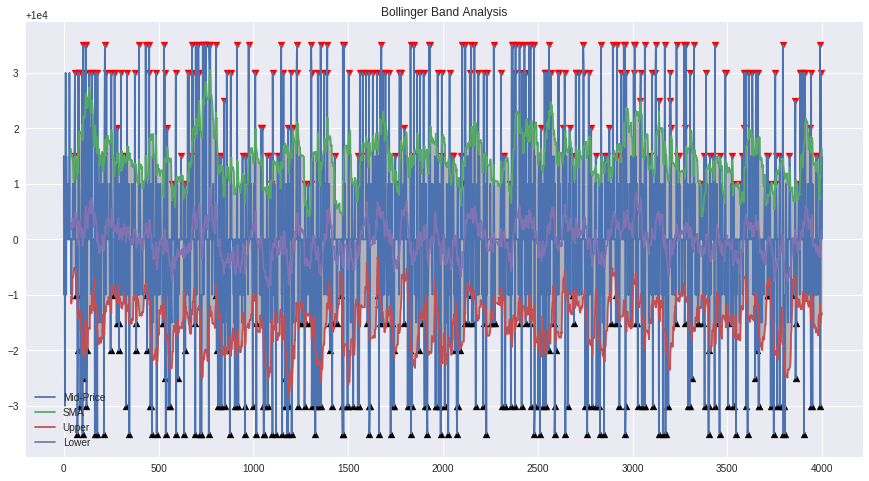

In [27]:
plt.figure(figsize = (15,8))
plt.plot(df_pearl[['mid_price', 'Upper', 'Lower', 'SMA20']])
plt.fill_between(df_pearl.index, df_pearl.Upper, df_pearl.Lower, color = 'grey', alpha = 0.5)
plt.scatter(df_pearl.index[df_pearl.Buy_Signal], df_pearl[df_pearl.Buy_Signal].mid_price, marker = '^', color = 'black')
plt.scatter(df_pearl.index[df_pearl.Sell_Signal], df_pearl[df_pearl.Sell_Signal].mid_price, marker = 'v', color = 'red')
plt.title('Bollinger Band Analysis')
plt.legend(['Mid-Price', 'SMA', 'Upper', 'Lower'])

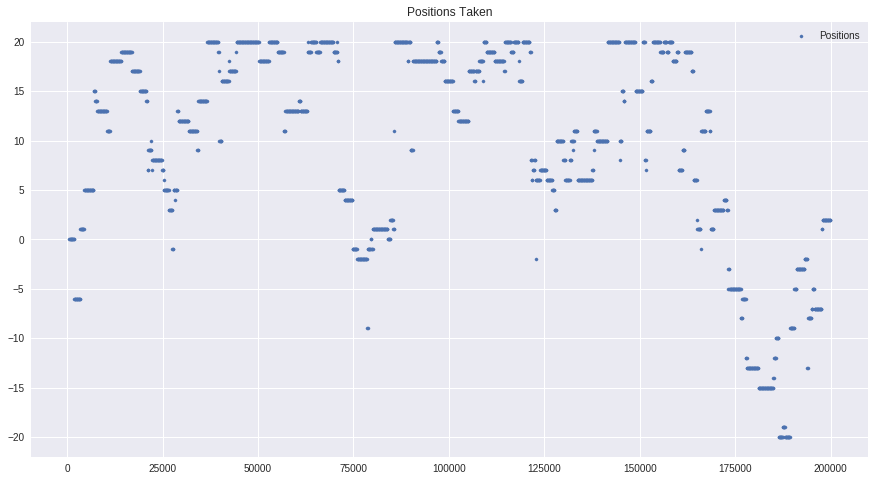

In [154]:
plt.figure(figsize = (15,8))
plt.scatter(df_positions['timestamp'], df_positions["PEARLS"], s=10)
plt.title('Positions Taken')
plt.legend(["Positions"])